In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mglearn
from matplotlib import rc, font_manager, rcParams
font_name = font_manager.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name()
rc("font", family=font_name)
# 음수기호 표시 안되는거 해결
rcParams["axes.unicode_minus"] = False
import scipy
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score

---
# 타이타닉 생존자 예측하기
    - https://www.kaggle.com/c/titanic/data
    - 목표 : 결과적으로 어떤 승객이 살아남았는지 죽었는지를 판단
---

## 데이터 준비하기

In [134]:
train = pd.read_csv('data/titanic/train.csv')
test = pd.read_csv('data/titanic/test.csv')

In [4]:
train.head()
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [135]:
train.shape  # (891, 12)
test.shape  # (418, 11)
train.info()
test.info()
train.isnull().sum()  # age, cabin, embarked 에 null값 존재
#test.isnull().sum()  # age, fare, cabin 에 null값 존재

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

## 탐색적 데이터 분석
    - Pclass
    - Sex
    - SibSp
    - Parch
    - Embarked
    - Cabin

In [136]:
def bar_chart(feature):
    survived = train[train["Survived"] == 1][feature].value_counts()  # 성별에 따라 몇 명이 살아남았는지를 막대그래프로
    dead = train[train["Survived"] == 0][feature].value_counts()
    df = pd.DataFrame([survived, dead])
    df.index = ["Survived", "Dead"]
    df.plot(kind="bar", stacked=True, figsize=(10, 5))

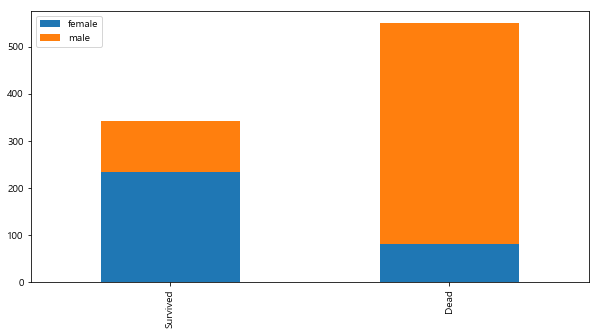

In [15]:
bar_chart("Sex")

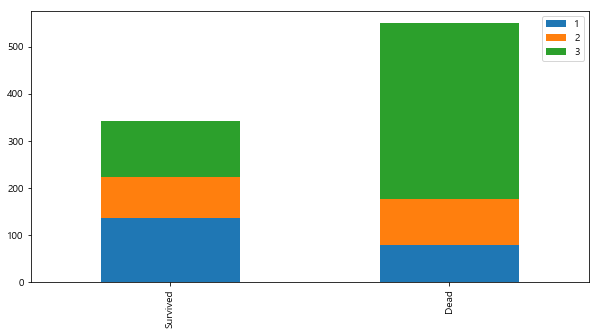

In [16]:
bar_chart("Pclass")

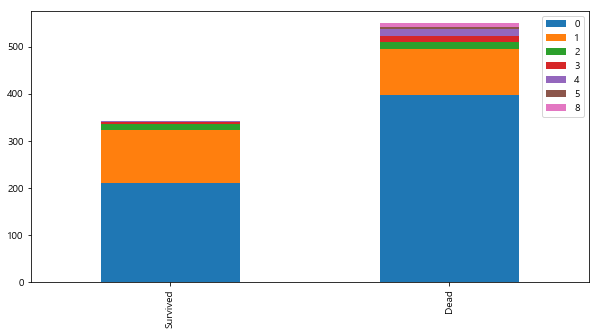

In [18]:
bar_chart("SibSp")

In [ ]:
# 승선을 어느 지역에서 했는지 (잘사는동네여부? - 객실등급과 관련 - 생존여부와도 관련)

## Feature Engineering

In [19]:
from IPython.display import Image
Image(url= "https://static1.squarespace.com/static/5006453fe4b09ef2252ba068/t/5090b249e4b047ba54dfd258/1351660113175/TItanic-Survival-Infographic.jpg?format=1500w")

### Name

In [137]:
train_test_data = [train, test] # 두개 데이터 합친 셋 만들기
for dataset in train_test_data:
    # 정규표현식 이
    dataset['Title'] = dataset['Name'].str.extract('([A-Za-z]+)\.', expand=False)

In [138]:
train.head()
test.head()
print(train["Title"].value_counts())
print(test["Title"].value_counts())

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Major         2
Mlle          2
Col           2
Sir           1
Countess      1
Ms            1
Capt          1
Jonkheer      1
Lady          1
Don           1
Mme           1
Name: Title, dtype: int64
Mr        240
Miss       78
Mrs        72
Master     21
Rev         2
Col         2
Ms          1
Dr          1
Dona        1
Name: Title, dtype: int64


In [139]:
title_mapping = {"Mr": 0, "Miss": 1, "Mrs": 2, "Master": 3, "Dr": 3, "Rev": 3, "Col": 3,
                 "Major": 3, "Mlle": 3, "Countess":3, "Ms":3, "Lady":3, "Jonkheer":3, "Don":3, "Dona":3, "Mme":3, "Capt":3,"Sir":3}
for dataset in train_test_data:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    
print(train.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  Title  
0      0         A/5 21171   7.2500   NaN        S      0  
1      0          PC 17599  71.2833   C85        C      2  
2      0  STON/O2. 3101282   7.9250   NaN        S      1  
3      0            113803  53.1000  C123        S      2  
4      0            

In [140]:
print(train["Title"].value_counts())
print(test["Title"].value_counts())

0    517
1    182
2    125
3     67
Name: Title, dtype: int64
0    240
1     78
2     72
3     28
Name: Title, dtype: int64


In [141]:
train["Title"].isnull().sum()
test["Title"].isnull().sum()

0

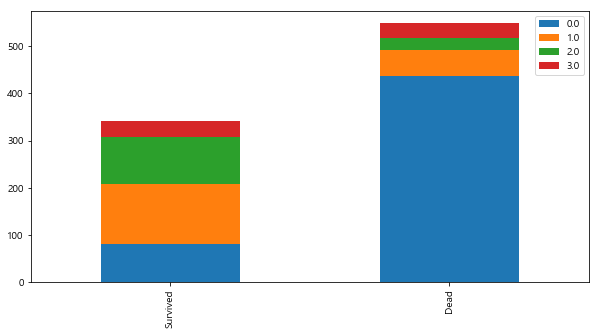

In [29]:
# 그래프로 확인
bar_chart("Title")

In [142]:
# Name 지우기
train.drop("Name", axis=1, inplace=True)
test.drop("Name", axis=1, inplace=True)

In [143]:
train.head()
test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,892,3,male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,female,47.0,1,0,363272,7.0000,NaN,S,2
2,894,2,male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,female,22.0,1,1,3101298,12.2875,NaN,S,2


In [144]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Title            0
dtype: int64

### Sex

In [145]:
sex_mapping = {"male":0, "female":1}
for dataset in train_test_data:
    dataset["Sex"] = dataset["Sex"].map(sex_mapping)

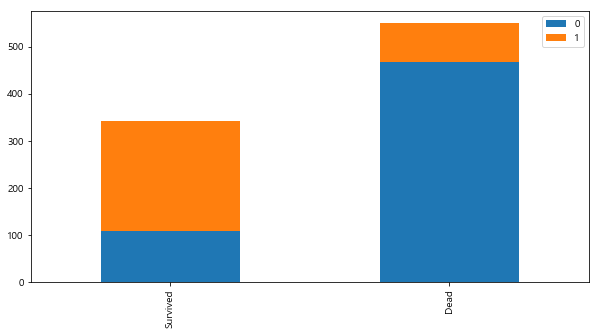

In [146]:
train.head()
test.head()
bar_chart("Sex")

### Age

In [147]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Title            0
dtype: int64

In [148]:
# 그룹으로 나눠서 중앙값 구하
train["Age"].fillna(train.groupby("Title")["Age"].transform("median"), inplace=True)
test["Age"].fillna(test.groupby("Title")["Age"].transform("median"), inplace=True)

In [149]:
train.isnull().sum()  # Age null값 다 채워진 것 확인가능

PassengerId      0
Survived         0
Pclass           0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Title            0
dtype: int64

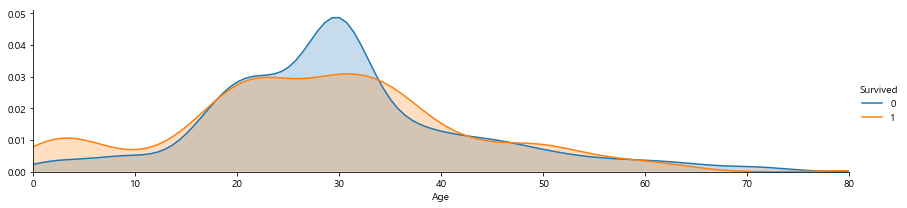

In [150]:
facet = sns.FacetGrid(train, hue="Survived", aspect=4)  # ascpect 옵션 : 그래프의 폭
facet.map(sns.kdeplot, "Age", shade=True)
facet.set(xlim=(0, train["Age"].max()))
# 범례 추가
facet.add_legend()

(0, 20)

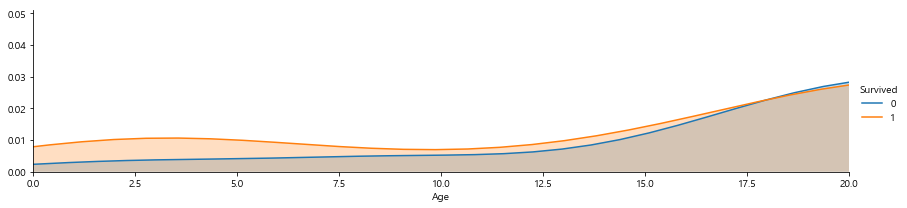

In [151]:
facet = sns.FacetGrid(train, hue="Survived", aspect=4)  # ascpect 옵션 : 그래프의 폭
facet.map(sns.kdeplot, "Age", shade=True)
facet.set(xlim=(0, train["Age"].max()))
# 범례 추가
facet.add_legend()
plt.xlim(0,20)

(20, 30)

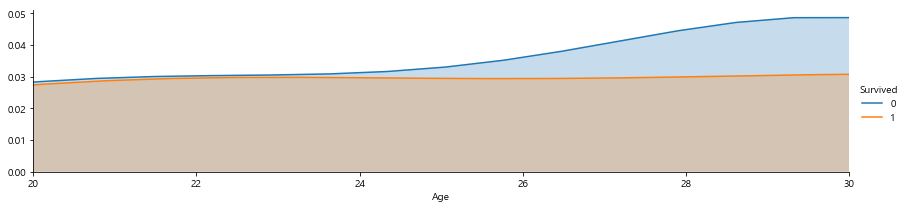

In [152]:
facet = sns.FacetGrid(train, hue="Survived", aspect=4)  # ascpect 옵션 : 그래프의 폭
facet.map(sns.kdeplot, "Age", shade=True)
facet.set(xlim=(0, train["Age"].max()))
# 범례 추가
facet.add_legend()
plt.xlim(20,30)

(30, 40)

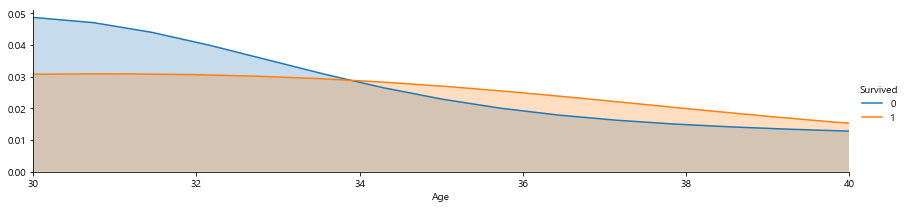

In [153]:
facet = sns.FacetGrid(train, hue="Survived", aspect=4)  # ascpect 옵션 : 그래프의 폭
facet.map(sns.kdeplot, "Age", shade=True)
facet.set(xlim=(0, train["Age"].max()))
# 범례 추가
facet.add_legend()
plt.xlim(30,40)

(40, 60)

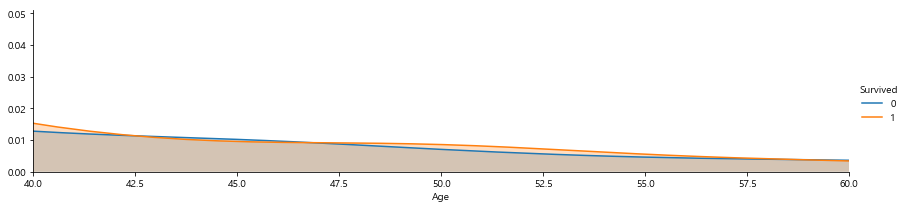

In [154]:
facet = sns.FacetGrid(train, hue="Survived", aspect=4)  # ascpect 옵션 : 그래프의 폭
facet.map(sns.kdeplot, "Age", shade=True)
facet.set(xlim=(0, train["Age"].max()))
# 범례 추가
facet.add_legend()
plt.xlim(40,60)

In [155]:
# Binning(child:0, young:1, adult:2, mid-age:3, senior:4)
for dataset in train_test_data:
    dataset.loc[dataset["Age"]<=16, "Age"] = 0
    dataset.loc[(dataset["Age"]>16) & (dataset["Age"]<=26), "Age"] = 1
    dataset.loc[(dataset["Age"]>26) & (dataset["Age"]<=36), "Age"] = 2
    dataset.loc[(dataset["Age"]>36) & (dataset["Age"]<=62), "Age"] = 3
    dataset.loc[dataset["Age"]>62, "Age"] = 4

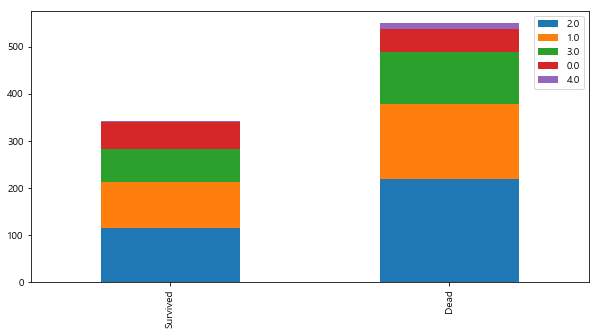

In [156]:
train.head()
test.head()
bar_chart("Age")

### Embarked

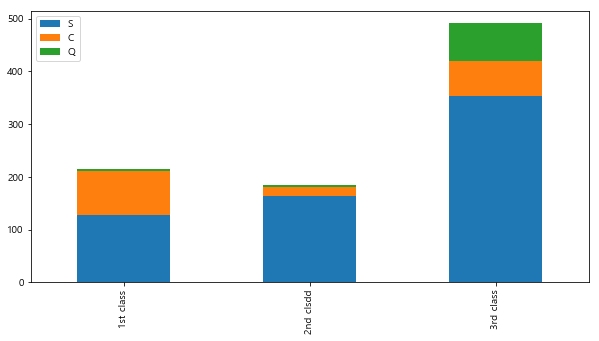

In [157]:
train.isnull().sum()  # cabin  Embarked  title

p1 = train[train['Pclass']==1]['Embarked'].value_counts()
p2 = train[train['Pclass']==2]['Embarked'].value_counts()
p3 = train[train['Pclass']==3]['Embarked'].value_counts()
df = pd.DataFrame([p1, p2, p3])
df.index = ['1st class', '2nd clsdd', '3rd class']
df.plot(kind='bar', stacked=True, figsize=(10,5))

In [158]:
for dataset in train_test_data:
    dataset["Embarked"] = dataset["Embarked"].fillna("S")

In [159]:
train.isnull().sum()
#train.head()

PassengerId      0
Survived         0
Pclass           0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
Title            0
dtype: int64

In [160]:
embarked_mapping = {"S":0, "C":1, "Q":2}
for dataset in train_test_data:
    dataset["Embarked"] = dataset["Embarked"].map(embarked_mapping)

In [161]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,0,1.0,1,0,A/5 21171,7.2500,NaN,0,0
1,2,1,1,1,3.0,1,0,PC 17599,71.2833,C85,1,2
2,3,1,3,1,1.0,0,0,STON/O2. 3101282,7.9250,NaN,0,1
3,4,1,1,1,2.0,1,0,113803,53.1000,C123,0,2
4,5,0,3,0,2.0,0,0,373450,8.0500,NaN,0,0


### Fare

In [162]:
test.isnull().sum()  # fare 1 : 객실등급을 보고 채워넣을 수 있다.
train.isnull().sum()  # fare 0

PassengerId      0
Survived         0
Pclass           0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
Title            0
dtype: int64

In [163]:
test["Fare"].fillna(test.groupby("Pclass")["Fare"].transform('median'), inplace=True)
test.isnull().sum()  # 결측치가 median값으로 채워

PassengerId      0
Pclass           0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
Title            0
dtype: int64

(0, 20)

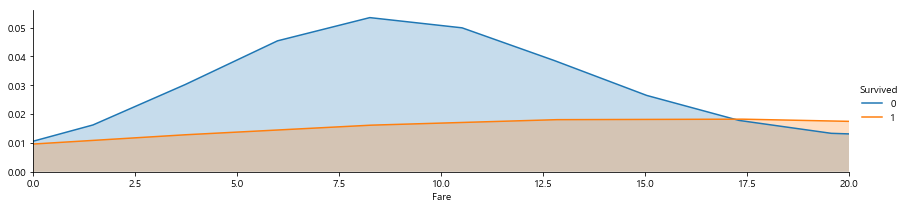

In [164]:
facet = sns.FacetGrid(train, hue="Survived", aspect=4)  # ascpect 옵션 : 그래프의 폭
facet.map(sns.kdeplot, "Fare", shade=True)
facet.set(xlim=(0, train["Fare"].max()))
# 범례 추가
facet.add_legend()
plt.xlim(0,20)

(20, 30)

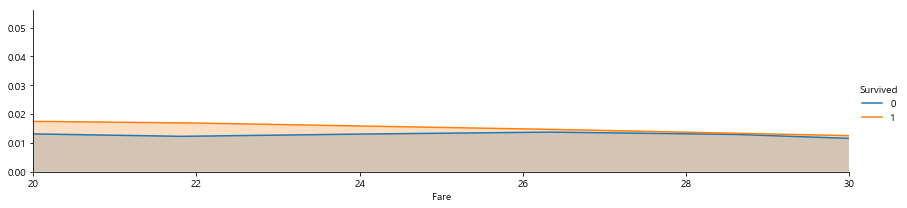

In [165]:
facet = sns.FacetGrid(train, hue="Survived", aspect=4)  # ascpect 옵션 : 그래프의 폭
facet.map(sns.kdeplot, "Fare", shade=True)
facet.set(xlim=(0, train["Fare"].max()))
# 범례 추가
facet.add_legend()
plt.xlim(20,30)

In [166]:
for dataset in train_test_data:
    dataset.loc[dataset["Fare"]<=17, "Fare"] = 0
    dataset.loc[(dataset["Fare"]>17) & (dataset["Fare"]<=30), "Fare"] = 1
    dataset.loc[(dataset["Fare"]>30) & (dataset["Fare"]<=100), "Fare"] = 2
    dataset.loc[dataset["Fare"]>100, "Fare"] = 3

In [167]:
train.head()
test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,892,3,0,2.0,0,0,330911,0.0,NaN,2,0
1,893,3,1,3.0,1,0,363272,0.0,NaN,0,2
2,894,2,0,3.0,0,0,240276,0.0,NaN,2,0
3,895,3,0,2.0,0,0,315154,0.0,NaN,0,0
4,896,3,1,1.0,1,1,3101298,0.0,NaN,0,2


### Cabin

In [168]:
train.Cabin.value_counts()

for dataset in train_test_data:
    dataset["Cabin"] = dataset["Cabin"].str[:1]  # 첫번쨰 글자만 받아서 재지정

In [169]:
train.Cabin.value_counts()

C    59
B    47
D    33
E    32
A    15
F    13
G     4
T     1
Name: Cabin, dtype: int64

In [170]:
p1 = train[train["Pclass"] ==1]["Cabin"].value_counts()
p2 = train[train["Pclass"] ==2]["Cabin"].value_counts()
p3 = train[train["Pclass"] ==3]["Cabin"].value_counts()

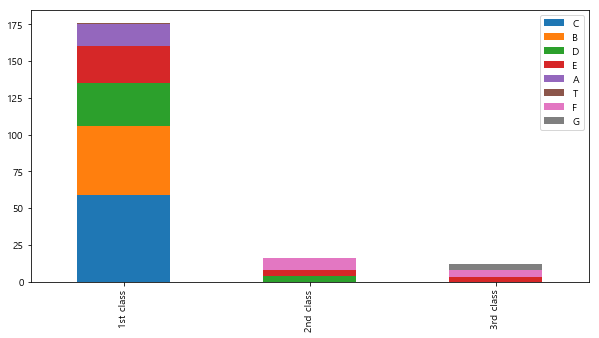

In [171]:
df = pd.DataFrame([p1, p2, p3])
df.index = ["1st class", "2nd class", "3rd class"]
df.plot(kind='bar', stacked=True, figsize=(10,5))

In [172]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,0,1.0,1,0,A/5 21171,0.0,NaN,0,0
1,2,1,1,1,3.0,1,0,PC 17599,2.0,C,1,2
2,3,1,3,1,1.0,0,0,STON/O2. 3101282,0.0,NaN,0,1
3,4,1,1,1,2.0,1,0,113803,2.0,C,0,2
4,5,0,3,0,2.0,0,0,373450,0.0,NaN,0,0


In [173]:
cabin_mapping = {"A":0, "B":0.4, "C":0.8, "D":1.2, "E":1.6, "F":2, "G":2.4, "T":2.8}
for dataset in train_test_data:
    dataset["Cabin"] = dataset["Cabin"].map(cabin_mapping)

In [174]:
train["Cabin"].fillna(train.groupby("Pclass")["Cabin"].transform("median"), inplace=True)
test["Cabin"].fillna(test.groupby("Pclass")["Cabin"].transform("median"), inplace=True)

In [175]:
train.isnull().sum()
test.isnull().sum()

PassengerId    0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
Title          0
dtype: int64

### Family Size

In [176]:
train["FamilySize"] = train["SibSp"] + train["Parch"] + 1   # + 1 은 뭐지?
test["FamilySize"] = test["SibSp"] + test["Parch"] + 1

In [177]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize
0,1,0,3,0,1.0,1,0,A/5 21171,0.0,2.0,0,0,2
1,2,1,1,1,3.0,1,0,PC 17599,2.0,0.8,1,2,2
2,3,1,3,1,1.0,0,0,STON/O2. 3101282,0.0,2.0,0,1,1
3,4,1,1,1,2.0,1,0,113803,2.0,0.8,0,2,2
4,5,0,3,0,2.0,0,0,373450,0.0,2.0,0,0,1


(0, 5)

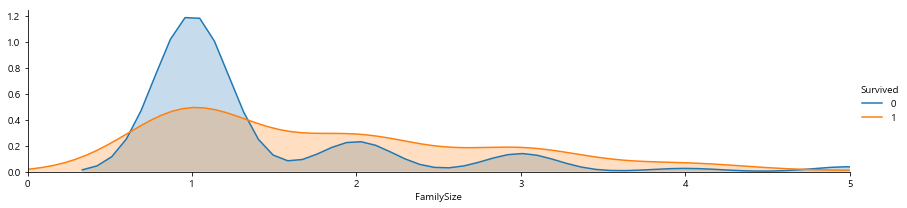

In [178]:
facet = sns.FacetGrid(train, hue="Survived", aspect=4)  # ascpect 옵션 : 그래프의 폭
facet.map(sns.kdeplot, "FamilySize", shade=True)
facet.set(xlim=(0, train["FamilySize"].max()))
# 범례 추가
facet.add_legend()
plt.xlim(0,5)

In [179]:
train["FamilySize"].value_counts()

1     537
2     161
3     102
4      29
6      22
5      15
7      12
11      7
8       6
Name: FamilySize, dtype: int64

In [180]:
# scale 줄이기
family_mapping = {1:0, 2:0.4, 3:0.8, 4: 1.2, 5:1.6, 6:2, 7:2.4, 8:2.8, 9:3.2, 10:3.6, 11:4}
for dataset in train_test_data:
    dataset["FamilySize"] = dataset["FamilySize"].map(family_mapping)

In [181]:
train.head()
test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize
0,892,3,0,2.0,0,0,330911,0.0,2.0,2,0,0.0
1,893,3,1,3.0,1,0,363272,0.0,2.0,0,2,0.4
2,894,2,0,3.0,0,0,240276,0.0,2.0,2,0,0.0
3,895,3,0,2.0,0,0,315154,0.0,2.0,0,0,0.0
4,896,3,1,1.0,1,1,3101298,0.0,2.0,0,2,0.8


In [182]:
features_drop = ["Ticket", "SibSp", "Parch"]
train = train.drop(features_drop, axis=1)
test = test.drop(features_drop, axis=1)
train = train.drop(["PassengerId"], axis=1)

In [183]:
train.head()
test.head()

,PassengerId,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,FamilySize
0,892,3,0,2.0,0.0,2.0,2,0,0.0
1,893,3,1,3.0,0.0,2.0,0,2,0.4
2,894,2,0,3.0,0.0,2.0,2,0,0.0
3,895,3,0,2.0,0.0,2.0,0,0,0.0
4,896,3,1,1.0,0.0,2.0,0,2,0.8


In [184]:
# 정답빼고 데이터 넘기기
train_data = train.drop("Survived", axis=1)
target = train["Survived"]

In [185]:
train_data.shape,target.shape  # ((891, 8), (891,))

((891, 8), (891,))

## (머신러닝을 위한) Modeling
    - KNN, Decision Tree, Random Forest, Naive Bayes, SVM
    - K-fold cross validation

In [186]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# 타이타닉 자료 연속변수?
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [187]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
Survived      891 non-null int64
Pclass        891 non-null int64
Sex           891 non-null int64
Age           891 non-null float64
Fare          891 non-null float64
Cabin         891 non-null float64
Embarked      891 non-null int64
Title         891 non-null int64
FamilySize    891 non-null float64
dtypes: float64(4), int64(5)
memory usage: 62.7 KB


In [188]:
# Cross Validation(K-fold)
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

In [189]:
# KNN
clf = KNeighborsClassifier(n_neighbors = 13)
score = cross_val_score(clf,train_data, target, cv=k_fold, n_jobs=1, scoring="accuracy")
print(score)

[0.82222222 0.76404494 0.80898876 0.83146067 0.87640449 0.82022472
 0.85393258 0.79775281 0.84269663 0.84269663]


In [190]:
# KNN의 성적
round(np.mean(score)*100, 2)

82.6

In [191]:
# Decision Tree
clf = DecisionTreeClassifier()
score = cross_val_score(clf, train_data, target, cv=k_fold, n_jobs=1, scoring="accuracy")
print(score)

[0.76666667 0.82022472 0.7752809  0.7752809  0.88764045 0.75280899
 0.82022472 0.82022472 0.74157303 0.79775281]


In [192]:
# Decision Tree 의 성적
round(np.mean(score)*100, 2)

79.58

In [194]:
# Random Forest
clf = RandomForestClassifier(n_estimators=13)
score = cross_val_score(clf, train_data, target, cv=k_fold, n_jobs=1, scoring='accuracy')
print(score)
print(round(np.mean(score)*100, 2))

[0.77777778 0.83146067 0.78651685 0.7752809  0.8988764  0.82022472
 0.82022472 0.80898876 0.76404494 0.82022472]
81.04


In [195]:
#Naive Bayes
clf = GaussianNB()
score = cross_val_score(clf, train_data, target, cv=k_fold, n_jobs=1, scoring='accuracy')
print(score)
print(round(np.mean(score)*100,2))

[0.85555556 0.73033708 0.75280899 0.75280899 0.70786517 0.80898876
 0.76404494 0.80898876 0.86516854 0.83146067]
78.78


In [200]:
#SVM
clf = SVC()
score = cross_val_score(clf, train_data, target, cv=k_fold, n_jobs=1, scoring='accuracy')
print(score)

C:\Users\wjdqh\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\wjdqh\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\wjdqh\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\wjdqh\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarni

[0.83333333 0.80898876 0.83146067 0.82022472 0.84269663 0.82022472
 0.84269663 0.85393258 0.83146067 0.86516854]


C:\Users\wjdqh\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\wjdqh\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\wjdqh\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [199]:
# SVM 성적
print(round(np.mean(score)*100, 2))

83.5


## Testing

In [201]:
# 훈련시키기 : fit()
clf = SVC().fit(train_data, target)

C:\Users\wjdqh\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [202]:
test_data = test.drop("PassengerId", axis=1).copy()

In [204]:
test_data.head()

,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,FamilySize
0,3,0,2.0,0.0,2.0,2,0,0.0
1,3,1,3.0,0.0,2.0,0,2,0.4
2,2,0,3.0,0.0,2.0,2,0,0.0
3,3,0,2.0,0.0,2.0,0,0,0.0
4,3,1,1.0,0.0,2.0,0,2,0.8


In [203]:
prediction = clf.predict(test_data)

In [205]:
submission = pd.DataFrame({
    "PassengerId":test["PassengerId"],
    "Survived":prediction})
 
submission.to_csv('submission.csv', index=False) #CSV전환
submission = pd.read_csv('submission.csv')
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [ ]:
# kaggle에 submission.csv 제출하여 평가받기